In [1]:
import argparse
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.fftpack import fftshift, ifftshift
from pyfftw.interfaces.scipy_fftpack import fft2, ifft2,fftn,ifftn

<h2>Implementación do filtro paso baixa para imaxes</h2>

A seguinte celda contén a función que construe e aplica o filtro paso baixa a unha imaxe, así como funcións para reconstruir a imaxe a partir das respostas dos filtros e a visualización dos filtros no dominio de Fourier e no dominio espacial

In [2]:
def pasoBaixa(sigmaF,nscale,imaxe,mult):

    print(f"Con parametros: \
           \n\t-n escalas= {nscale}\
           \n\t-sigmaF= {sigmaF}\
           \n\t-mult= {mult} \n")
    
    rows,cols=imaxe.shape

    IM=fft2(imaxe)

    #construimos o espectro de Fourier con dimensions da imaxe para poder convolucionar
    if (cols % 2):
        xvals = np.arange(-(cols - 1) / 2.,
                          ((cols - 1) / 2.) + 1) / float(cols - 1)
    else:
        xvals = np.arange(-cols / 2., cols / 2.) / float(cols)

    if (rows % 2):
        yvals = np.arange(-(rows - 1) / 2.,
                          ((rows - 1) / 2.) + 1) / float(rows - 1)
    else:
        yvals = np.arange(-rows / 2., rows / 2.) / float(rows)

    x,y=np.meshgrid(xvals,yvals,sparse=True)
    radio=np.sqrt(x**2+y**2)
    radio = ifftshift(radio)
    radio[0,0]=1.0

    coberturas=[]
    convolved=[]
    bandwidth=[]
    
    #construimos o filtro en cada escala e convolucionamos coa imaxe
    for ss in range(nscale):

        f0=0.1
        NsigmaF=sigmaF*mult**ss #o ancho de banda do filtro cambia ca escala
        num=-np.log(radio/f0)
        denom=2*(np.log(NsigmaF/f0))**2
        component=np.exp(num**2/denom)

        component[0,0]=0.0
        convolved_result = ifft2(IM * component)
        convolved.append(convolved_result) #almacenamos o resultado do filtrado
        
        coberturas.append(component) #almacenamos o filtro
        
        BW=2*np.sqrt(2/np.log(2))*np.abs(np.log(NsigmaF/f0))
        bandwidth.append(BW)#almacenamos o ancho de banda na escala
        print("Ancho de banda na escala {}: {}".format(ss+1,BW))
        
    print("\n")
    
    return convolved, coberturas, bandwidth

def reconstrucion(imaxeFiltrada):
    
    #para realizar a reconstrucion, sumamos as partes reais das respostas o banco de filtros
    imaxeFiltrada=np.array(imaxeFiltrada)
    reconstruida=np.sum(np.real(imaxeFiltrada),axis=0)
    
    return reconstruida

def coberturasFiltros(filtros):
    
    #visualizamos os filtros no dominio espectral
    fig=plt.figure()
    for ss in range(escalas):
        ax=fig.add_subplot(1,escalas,ss+1)
        ax.imshow(fftshift(filtros[ss]),cmap="gray")
        plt.title("Escala: "+str(ss+1))
    
    fig.suptitle("Filtros no dominio espectral")
    plt.show()
    
    #visualizamos os filtros no dominion espacial
    fig=plt.figure()
    for ss in range(escalas):
        ax=fig.add_subplot(1,escalas,ss+1)
        ax.imshow(np.abs(fftshift(ifft2(filtros[ss]))))
        plt.title("Escala: "+str(ss+1))

    fig.suptitle("Filtros no dominio espacial")
    plt.show()

Realizamos varias probas con distintos parametros para observar o efecto dos mesmos sobre o banco de filtros.

In [4]:
imaxe=cv2.imread("../DATA/orange.png",0)
probas=[]
anchosBanda=[]

print("------Primeira proba------")
escalas,sigma,mult=5,0.3,1.3
resultados,filtros,bw=pasoBaixa(sigma,escalas,imaxe,mult)
probas.append(resultados)
anchosBanda.append(bw)

print("------Segunda proba------")
escalas,sigma1,mult1=5,0.85,1.3
resultados,filtros1,bw=pasoBaixa(sigma1,escalas,imaxe,mult1)
probas.append(resultados)
anchosBanda.append(bw)

print("------Terceira proba------")
escalas,sigma2,mult2=5,0.4,1.0
resultados,filtros2,bw=pasoBaixa(sigma2,escalas,imaxe,mult2)
probas.append(resultados)
anchosBanda.append(bw)

------Primeira proba------
Con parametros:            
	-n escalas= 5           
	-sigmaF= 0.3           
	-mult= 1.3 

Ancho de banda na escala 1: 3.732301467320559
Ancho de banda na escala 2: 4.623628225035644
Ancho de banda na escala 3: 5.514954982750731
Ancho de banda na escala 4: 6.406281740465817
Ancho de banda na escala 5: 7.297608498180902


------Segunda proba------
Con parametros:            
	-n escalas= 5           
	-sigmaF= 0.85           
	-mult= 1.3 

Ancho de banda na escala 1: 7.270419386864507
Ancho de banda na escala 2: 8.161746144579592
Ancho de banda na escala 3: 9.053072902294678
Ancho de banda na escala 4: 9.944399660009765
Ancho de banda na escala 5: 10.835726417724851


------Terceira proba------
Con parametros:            
	-n escalas= 5           
	-sigmaF= 0.4           
	-mult= 1.0 

Ancho de banda na escala 1: 4.709640090061899
Ancho de banda na escala 2: 4.709640090061899
Ancho de banda na escala 3: 4.709640090061899
Ancho de banda na escala 4: 4.7096400

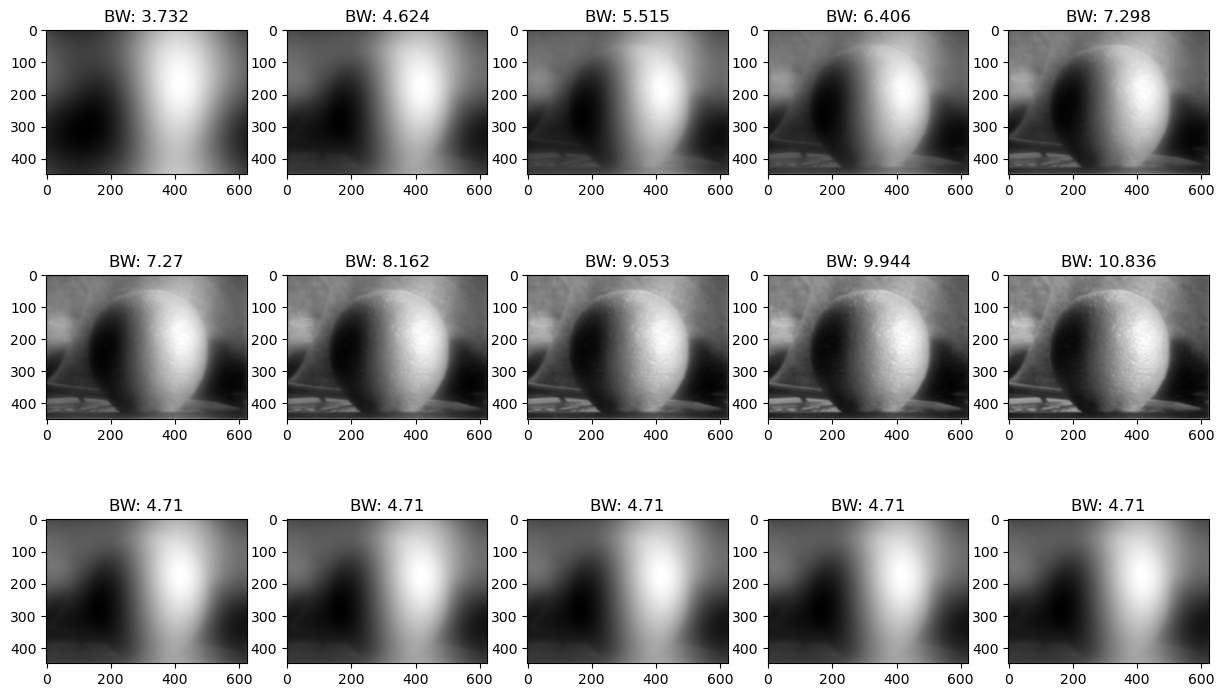

In [5]:
fig=plt.figure(figsize=(15,3*len(probas)))

for i in range(len(probas)):
    for j in range(len(probas[i])):
        plt.subplot(len(probas),len(probas[i]),i*len(probas[i])+j+1)
        
        plt.imshow(np.real(probas[i][j]),cmap="gray")

        plt.title(f"BW: {round(anchosBanda[i][j],3)}")
plt.show()

Na figura anterior observanse os resultados de aplicar o banco de filtros con distintos valores de sigma e de mult. Cada fila corresponde con unha proba diferente e cada imaxe está etiquetada co ancho de banda do filtro co que se convolucionou.

Estes parametros permiten axustar o ancho de banda do filtro, que está situado na frecuencia central, sendo mult a distancia entre os filtros de distintas escalas e sigma a apertura radial do filtro Gaussiano. O filtro ten centro fixo, na frecuencia central do espectro, é dicir, só podemos axustar o ancho de banda do filtro, anchos de banda baixos filtran só as frecuencias baixas, a medida que aumenta o BW, a convolución toma máis frecuencias do espectro porque o filtro ten maior apertura. 

Na primeira proba, a apertura radial é baixa pero hai certa separación entre os filtros de distintas escalas. Un sigma radial baixo provocará que as primeiras escalas do banco teñan moi pouco ancho de banda e só filtren as frecuencias baixas, a medida que o ancho dos filtros aumenta, "entran" máis frecuencias dentro da Gaussiana, o que quere dicir que se admiten tanto frecuencias altas como frecuencias baixas.

A segunda proba é un exemplo dunha apertura radial alta. Se temos un valor alto de sigma, non importa a separación dos filtros, as primeiras escalas xa admitirán máis frecuencias que as que buscamos filtrar no paso baixa.

Na terceira proba tomamos un valor baixo de sigma pero damoslle valor 1 ao parámetro de separación entre escalas. Desta maneira, o ancho de banda permanece constante e sempre se filtran as frecuencias baixas de imaxe.

En conclusion, se queremos que se filtren só as frecuencias baixas da imaxe, debemos manter unha apertura de filtro reducida e a separación entre os filtros de diferentes escalas tamén baixa, para que o cambio no ancho de banda non sexa alto a medida que se cambia de escala.

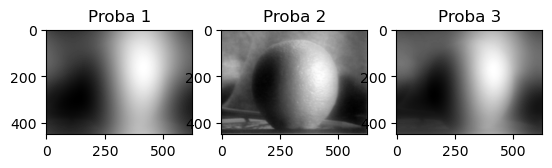

In [6]:
#mostramos a reconstrucion da imaxe
for i in range(len(probas)):
    plt.subplot(1,len(probas),i+1)
    imRec=reconstrucion(probas[i])
    plt.imshow(imRec,cmap="gray")
    
    plt.title(f"Proba {i+1}")
    
plt.show()

Para reconstruir as imaxes sumamos as partes reais das respostas dos filtros. Se só filtramos as frecuencias baixas, a reconstrución verase difuminada, xa que as respostas correspondense só con frecuencias baixas da imaxe orixinal.

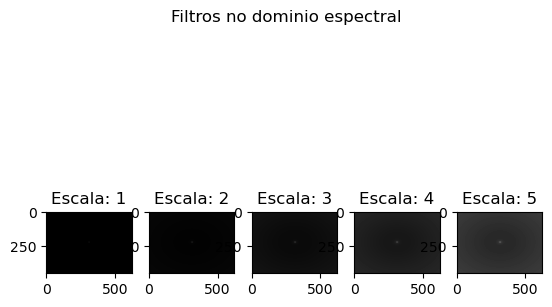

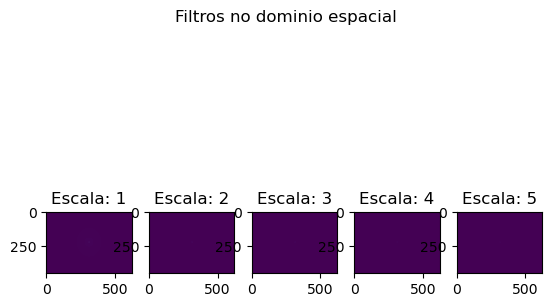

In [7]:
#mostramos as coberturas espectrais e espaciais dos filtros
coberturasFiltros(filtros)

As imaxes anteriores mostran os filtros no espectro de Fourier e no dominio espacial para a primeira proba. Vemos como no espectro de fourier aumenta o tamaño do filtro a medida que aumentamos o ancho de banda. Porén, non sucede o mesmo no dominio espacial, onde todos os filtros parecen ter o mesmo tamaño. 

Esto débese a que, se a gaussiana ten unha alta cobertura frecuencial no espazo de Fourier, terá unha cobertura espacial reducida e vice-versa:

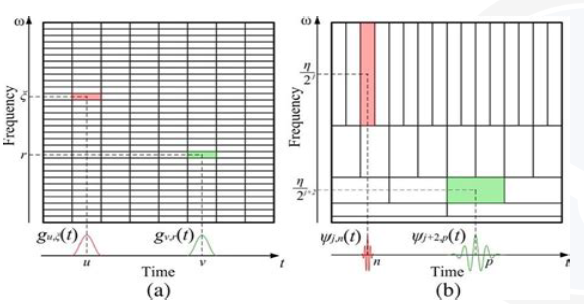

<h2>Implementación do filtro paso baixa para vídeo</h2>

In [2]:
def pasoBaixaVideo(sigmaF, nscale, minlonguraOnda, frameArray, mult):
    
    '''aplica o filtrado paso baixa a un video'''
    print(frameArray.shape)
    filas,columnas,frames=frameArray.shape
	
    #desta volta, cando construimos o espectro, debemos ter en conta a terceira dimensión do vídeo (os frames)
    IM=fftn(frameArray)
    resultados=[]
    if(columnas%2==0):
        xvals=np.arange(-(columnas-1)/2.0,((columnas-1)/2.0)+1)/float(columnas-1)
        
    else:
        xvals=np.arange(-columnas/2.0,columnas/2.0)/float(columnas)
        
    if (filas%2):
        yvals=np.arange(-(filas-1)/2.0,((filas-1)/2.0)+1)/float(filas-1)
        
    else:
        yvals=np.arange(-filas/2.0,filas/2.0)/float(filas)

    if(frames%2):
        zvals=np.arange(-(frames-1)/2.0,((frames-1)/2.0)+1)/float(frames-1)

    else:
        zvals=np.arange(-frames/2.0,frames/2.0)/float(frames)

    x,y,z=np.meshgrid(xvals,yvals,zvals)
    radio=np.sqrt(x**2+y**2+z**2)
    radio=ifftshift(radio)
    radio[0,0]=1.0

    #aplicamos o filtro de cada escala o video,
    for ss in range(nscale):
        f0=0.1
        NsigmaF=sigmaF*mult**ss
        
        BW=2*np.sqrt(2/np.log(2))*np.abs(np.log(NsigmaF/f0))
        print("Para a escala {}, BW {}".format(ss,BW))
        
        num=-np.log(radio/f0)
        denom=2*(np.log(NsigmaF/f0))**2
        component=np.exp(num**2/denom)

        component[0,0]=0.0

        #resposta de filtrar o video
        resultados.append(ifftn(IM*component))

    return resultados

def mostrarFiltradoVideo(resultados):
    num_videos = len(resultados)
    num_frames = 5 #numero de frames que se van amosar de cada video

    fig, axes = plt.subplots(num_videos, num_frames, figsize=(15, 3 * num_videos))

    #para cada video mostramos 5 frames
    for i in range(num_videos):
        video_array = resultados[i]

        for j in range(num_frames):
            frame_index = int(len(video_array) * j / num_frames)
            frame = video_array[frame_index]

            axes[i, j].imshow(np.real(frame),cmap="gray")
        
            axes[i,j].set_title("Escala "+str(i))
            
    plt.show()

In [5]:
cap=cv2.VideoCapture("../DATA/SCE_bur_11_girando.avi")
frames=[]

while cap.isOpened():

    ret,frame=cap.read()

    if not ret:
        break

    frame=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    frames.append(frame)

frames=np.array(frames)
escalas=2
resultados=pasoBaixaVideo(0.35,2,3,frames,0.75)

(302, 240, 320)
Para a escala 0, BW 4.255995598946595
Para a escala 1, BW 3.2786569762052555


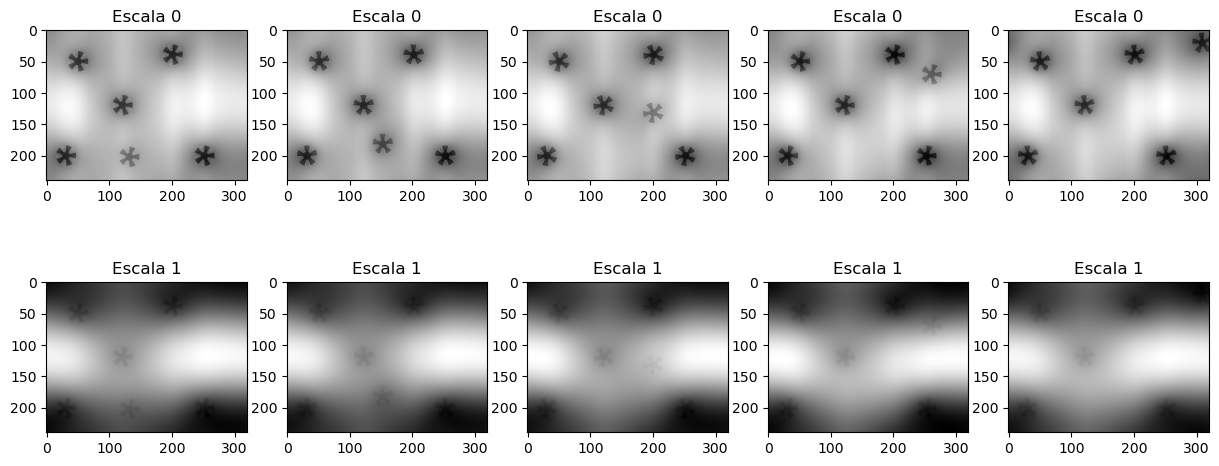

In [6]:
#amosamos o resultado de aplicar o filtrado o video, mostranse cinco frames para cada escala
mostrarFiltradoVideo(resultados)

No caso do vídeo, o filtro aplícase por igual a todos os frames, quedandonos con diferentes frecuencias do vídeo en función da escala do banco e do ancho de banda.